# Computational Intelligence Project: Sentiment Analysis on IMDB dataset 

Sentiment analysis is one of the key areas of research in NLP and Sequence modelling. I will be using LSTMs and Bi-directional LSTMs to predict two classes - positive or negative sentiment. 
In this Notebook i'll follow the Neural Networks for sentiment analysis.

**Part A Report**

In this Project i have loaded the imdb dataset. The Dataset was in raw format. I applied the preprocessing on dataset using regular expressions and simple substituion. After cleaning the dataset [Removing html tags, single aphabets, delimeters, word's contractions, alphanumeric charactors and punctuations.] After cleaning i used the nltk library to generate the stopword and mapped it on dataframe. 
Then i split the dataset into training and test 70/30 ratio and tokenize them and map each token to integer. after that i add the padding and build the model. Total number of unique token i have found in the df is 9999 and min length of review is 17 and max is 9193. 

**LSTM:**

Lstm model has 3 layers embedding, Lstm  and dense layer.  LSTM model gave me 88.4% validation accuray over 100 dim input and 98% accuracy in training case. I have performed over 50 epochs to train the model in chunks. The graph are generated below. 

**Bidirectional LSTM:**

BiLstm model has 3 layers embedding, Lstm  and dense layer.  Bi LSTM model gave me 88.6% validation accuray and 98% accuracy in training case. I have performed in total for multiple epochs to train the model in chunks. I trained the model and save it for further iteration. last iteration is stopped due to no improvement. The graph are generated below. BiLstm was the best of the all.I saved the model and then load the model to perform further iterations.

**3rd Model:**
total params are 1729 but i have tried different params till 8008 but result was not more than 74%. 

In the end, i have tried 10 different examples to test the prediction using bilstm model and results was significantly great.

**Optimizers:**

Adam and RMSProp were used during the traing.

**Initializers:** 

Uniform initialization was used.

**Loss Functions:**

Sigmoid and Relu were used.

In [1]:
import numpy as np 
import pandas as pd 
from keras.datasets import imdb
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Conv1D, Dropout, Bidirectional, Input, Flatten, GlobalMaxPool1D, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split

#-------------------------
import os
import re
import nltk
nltk.download("stopwords")
nltk.download('punkt')
from nltk.corpus import stopwords
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau, TensorBoard
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from nltk import word_tokenize 
import seaborn as sns


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Data handling - exploration and cleaning



In [2]:
from google.colab import drive
drive.mount('/content/drive')

dataset = "IMDB Dataset.csv"
drive_path = '/content/drive/My Drive/Computational Intelligence/'
path = os.path.join(drive_path, dataset)
df = pd.read_csv(path)

Mounted at /content/drive


In [3]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [ ]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


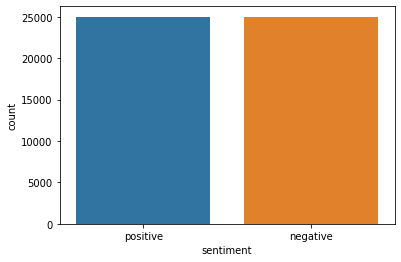

In [ ]:
sns.countplot(x="sentiment",data=df)

### Step 1: Remove Contraction

In [4]:
contractions = {
"ain't": "am not / are not", "aren't": "are not / am not","can't": "cannot","can't've": "cannot have","'cause": "because",
"could've": "could have","couldn't": "could not","couldn't've": "could not have","didn't": "did not","doesn't": "does not",
"don't": "do not","hadn't": "had not","hadn't've": "had not have","hasn't": "has not","haven't": "have not",
"he'd": "he had / he would","he'd've": "he would have","he'll": "he shall / he will",
"he'll've": "he shall have / he will have","he's": "he has / he is","how'd": "how did","how'd'y": "how do you",
"how'll": "how will","how's": "how has / how is","i'd": "I had / I would","i'd've": "I would have","i'll": "I shall / I will",
"i'll've": "I shall have / I will have","i'm": "I am","i've": "I have","isn't": "is not","it'd": "it had / it would",
"it'd've": "it would have","it'll": "it shall / it will","it'll've": "it shall have / it will have","it's": "it has / it is",
"let's": "let us","ma'am": "madam","mayn't": "may not",
"might've": "might have","mightn't": "might not","mightn't've": "might not have","must've": "must have","mustn't": "must not",
"mustn't've": "must not have","needn't": "need not","needn't've": "need not have","o'clock": "of the clock",
"oughtn't": "ought not","oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
"shan't've": "shall not have","she'd": "she had / she would","she'd've": "she would have","she'll": "she shall / she will",
"she'll've": "she shall have / she will have","she's": "she has / she is","should've": "should have","shouldn't": "should not",
"shouldn't've": "should not have","so've": "so have","so's": "so as / so is","that'd": "that would / that had",
"that'd've": "that would have","that's": "that has / that is","there'd": "there had / there would",
"there'd've": "there would have","there's": "there has / there is","they'd": "they had / they would",
"they'd've": "they would have","they'll": "they shall / they will","they'll've": "they shall have / they will have",
"they're": "they are","they've": "they have","to've": "to have","wasn't": "was not","we'd": "we had / we would",
"we'd've": "we would have","we'll": "we will","we'll've": "we will have","we're": "we are","we've": "we have",
"weren't": "were not","what'll": "what shall / what will","what'll've": "what shall have / what will have",
"what're": "what are","what's": "what has / what is","what've": "what have","when's": "when has / when is",
"when've": "when have","where'd": "where did","where's": "where has / where is","where've": "where have","who'll": "who shall / who will",
"who'll've": "who shall have / who will have","who's": "who has / who is","who've": "who have","why's": "why has / why is",
"why've": "why have","will've": "will have","won't": "will not","won't've": "will not have","would've": "would have",
"wouldn't": "would not","wouldn't've": "would not have","y'all": "you all","y'all'd": "you all would",
"y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you had / you would",
"you'd've": "you would have","you'll": "you shall / you will","you'll've": "you shall have / you will have",
"you're": "you are","you've": "you have"
}

In [5]:
def identify_contractions(dataframe):
    for i in range(0, len(dataframe)):
        for word in dataframe[i].split():
            if word.lower() in contractions:
                dataframe[i] = dataframe[i].replace(word, contractions[word.lower()])
    return dataframe

### Step 2: Stop Word Removal

In [6]:
def eng_stopwords(dataframe):
    stopwords_ = set(stopwords.words("english"));
    for row in dataframe.index:
        txt = dataframe.loc[row, 'review'].split();
        dataframe.loc[row, 'review']  = ' '.join([word for word in txt if word not in stopwords_]);
    return dataframe

### Step 3: Remove  HTML tags, alphanumeric Words, Punctuation, emails using Regex

In [7]:
regex_ = re.compile("[.;:!%&*@\'?,\"()\[\]]")
regex_space = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
regex_url = re.compile("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+");
regex_alphanumerics = re.compile("[^a-zA-Z0-9' ]");

df['review'] = identify_contractions(df['review'])
df['review'] = [regex_.sub("", line.lower()) for line in df['review']]
df['review'] = [regex_space.sub("", line) for line in df['review']]
df['review'] = [regex_url.sub(" ", line) for line in df['review']]
df['review'] = [regex_alphanumerics.sub("", line.lower()) for line in df['review']]
df['review'] = [re.sub(r"\b[a-zA-Z]\b", "", line) for line in df['review']]

In [8]:
df['review'][4]

'petter matteis love in the time of money is  visually stunning film to watch mr mattei offers us  vivid portrait about human relations this is  movie that seems to be telling us what money power and success do to people in the different situations we encounter this being  variation on the arthur schnitzlers play about the same theme the director transfers the action to the present time new york where all these different characters meet and connect each one is connected in one way or another to the next person but no one seems to know the previous point of contact stylishly the film has  sophisticated luxurious look we are taken to see how these people live and the world they live in their own habitatthe only thing one gets out of all these souls in the picture is the different stages of loneliness each one inhabits  big city is not exactly the best place in which human relations find sincere fulfillment as one discerns is the case with most of the people we encounterthe acting is good

## Data Exploration

In [ ]:
# visualisation
def visualization(dfi):
  X = dfi.iloc[:,0].values
  y = dfi.iloc[:,1].values

  dfi["len"] = np.array([len(i) for i in X])

  neg = dfi.where(dfi["sentiment"]=='negative').dropna().reset_index().drop(["index"],axis=1)
  pos = dfi.where(dfi["sentiment"]=='positive').dropna().reset_index().drop(["index"],axis=1)
  return pos, neg
pos, neg = visualization(df)

In [ ]:
from wordcloud import WordCloud,STOPWORDS

def plot_wordcloud(data):
    words = '' 
    stopwords = set(STOPWORDS) 
    for val in data.values: 
        val = str(val) 
        tokens = val.split() 
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower() 

        words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 400, height = 400, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(words)                        
    plt.figure(figsize = (5,5), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0)
    plt.show()
                  

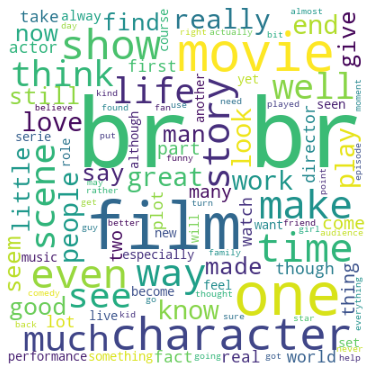

In [ ]:
plot_wordcloud(pos["review"])

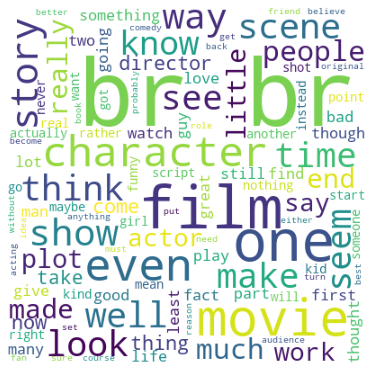

In [ ]:
plot_wordcloud(neg["review"])

In [9]:
df = eng_stopwords(df)

In [10]:
dataframe = df
dataframe

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake thinks zombie...,negative
4,petter matteis love time money visually stunni...,positive
...,...,...
49995,thought movie right good job creative original...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,catholic taught parochial elementary schools n...,negative
49998,going disagree previous comment side maltin on...,negative


## Model processing


In [11]:
print(dataframe.shape)

for i in range (0, len(dataframe)):
    if dataframe['sentiment'][i] == 'positive':
        dataframe['sentiment'][i] = 1
    else:
        dataframe['sentiment'][i] = 0
        

X_train, X_test, y_train, y_test = train_test_split(dataframe.review, dataframe.sentiment, test_size=0.3, random_state=37)

(50000, 2)


In [12]:
X_train.shape, y_train.shape
data = np.concatenate((X_train, X_test), axis=0)
target = np.concatenate((y_train, y_test), axis=0)

In [13]:
print("Number of distinct words:", len(np.unique(np.hstack(data))))
length = [len(i) for i in data]
print("Min Review length:", np.min(length))
print("Max Review length:", np.max(length))


Number of distinct words: 49578
Min Review length: 17
Max Review length: 9181


### Tokenizer
Tokenizer creates a dictionary of word to integer mappings. It updates internal vocabulary based on a list of texts.



In [14]:
NoWords = 10000
regex = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
MaxLen = 500
emb_size=32
BatchSize=128
Epochs=10

In [15]:
tokenizer = Tokenizer(num_words=NoWords,
               filters=regex,
               lower=True,
               split=" ")
data = np.concatenate((X_train, X_test), axis=0)
tokenizer.fit_on_texts(data)


X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [16]:
tok_len = np.concatenate((X_train_seq, X_test_seq), axis=0)
print("Number of distinct Tokens:", len(np.unique(np.hstack(tok_len))))


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Number of distinct Tokens: 9999


In [17]:
#seq_lengths = X_train.apply(lambda x: len(x.split(' ')))
X_train_pad = pad_sequences(X_train_seq, maxlen=MaxLen )
X_test_pad = pad_sequences(X_test_seq, maxlen=MaxLen)

In [18]:
xtr = np.asarray(X_train_pad).astype(np.float32)
ytr = np.asarray(y_train).astype(np.float32)
xte = np.asarray(X_test_pad).astype(np.float32)
yte = np.asarray(y_test).astype(np.float32)



## Model Engineering

So i have trained 3 of models from scratch to evalate the performance on IMDB dataset.

1.   Using LSTMs
2.   Bi-directional LSTMs
3.   CNN Model


In [19]:
model_name_l = 'lstm_model'
model_path_l = os.path.join(drive_path, model_name_l)

# if not os.path.exists('./'+model_path_l):
#     os.mkdir(model_name_l)

l_checkpoint = ModelCheckpoint(model_name_l+'/'+model_name_l+'-{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
l_reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001, min_delta=0.03)

l_callbacks = [l_checkpoint, l_reducelr]


In [20]:
#using LSTM
model=Sequential()
model.add(Embedding(NoWords, emb_size, input_length=MaxLen))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 32)           320000    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 373,301
Trainable params: 373,301
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(xtr, ytr,  
                    validation_data=(xte, yte), 
                    epochs=10, 
                    callbacks=l_callbacks, 
                    batch_size=128, 
                    verbose=1)



Epoch 1/10
274/274 [==============================] - 45s 51ms/step - loss: 0.5344 - accuracy: 0.7231 - val_loss: 0.3005 - val_accuracy: 0.8867

Epoch 00001: val_loss improved from inf to 0.30045, saving model to lstm_model/lstm_model-01-0.30.h5
Epoch 2/10
274/274 [==============================] - 14s 51ms/step - loss: 0.2124 - accuracy: 0.9211 - val_loss: 0.2747 - val_accuracy: 0.8857

Epoch 00002: val_loss improved from 0.30045 to 0.27465, saving model to lstm_model/lstm_model-02-0.27.h5
Epoch 3/10
274/274 [==============================] - 13s 48ms/step - loss: 0.1620 - accuracy: 0.9414 - val_loss: 0.3047 - val_accuracy: 0.8841

Epoch 00003: val_loss did not improve from 0.27465
Epoch 4/10
274/274 [==============================] - 14s 50ms/step - loss: 0.1334 - accuracy: 0.9537 - val_loss: 0.3567 - val_accuracy: 0.8815

Epoch 00004: val_loss did not improve from 0.27465
Epoch 5/10
274/274 [==============================] - 13s 48ms/step - loss: 0.0871 - accuracy: 0.9718 - val_loss

In [22]:
scores_tra = model.evaluate(xtr, ytr, verbose=0)
scores = model.evaluate(xte, yte, verbose=0)
print("Training Accuracy: %.2f%%" % (scores_tra[1]*100))
print("Test Accuracy: %.2f%%" % (scores[1]*100))

Training Accuracy: 98.89%
Test Accuracy: 87.61%


In [23]:
model.save_weights(drive_path + "/lstm_88.h5")


In [24]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

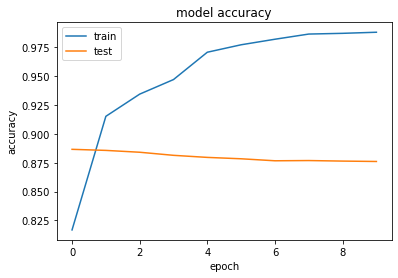

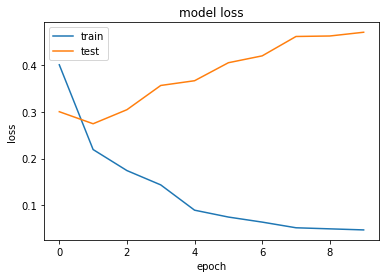

In [25]:
plot_accuracy(history)
plot_loss(history)

### Second Model Bidirectional

In [ ]:
# model_name = 'bidirectional_model'
# model_path = os.path.join(drive_path, model_name)

# if not os.path.exists('./'+model_path):
#     os.mkdir(model_name)


In [ ]:
b_checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
b_reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001, min_delta=0.03)

b_callbacks = [b_checkpoint, b_reducelr]

In [26]:
def bidirectional():
  embeddings=256
  model= Sequential()
  model.add(Embedding(NoWords,embeddings,input_length=MaxLen))
  model.add(Conv1D(256,10,activation='relu'))
  model.add(Bidirectional(LSTM(128,return_sequences=True)))
  model.add(LSTM(64))
  model.add(Dropout(0.4))
  model.add(Dense(1,activation='sigmoid'))
  model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
  return model

model_b2 = bidirectional()
model_b2.summary()
print('Training...')
history = model_b2.fit(xtr, ytr,  
                    validation_data=(xte, yte), 
                    epochs=5, 
                    # callbacks=l_callbacks, 
                    batch_size=128, 
                    verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 256)          2560000   
_________________________________________________________________
conv1d (Conv1D)              (None, 491, 256)          655616    
_________________________________________________________________
bidirectional (Bidirectional (None, 491, 256)          394240    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                82176     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 3,692,097
Trainable params: 3,692,097
Non-trainable params: 0
____________________________________________

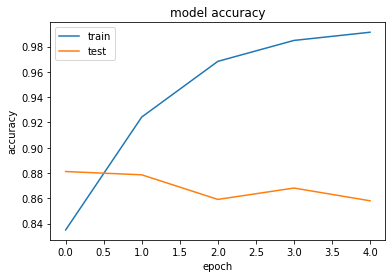

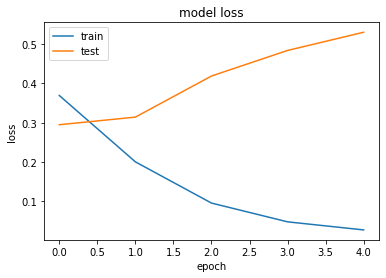

In [27]:
plot_accuracy(model_b2.history)
plot_loss(model_b2.history)

In [28]:
scores_br = model_b2.evaluate(xtr, ytr, verbose=0)
scores_b = model_b2.evaluate(xte, yte, verbose=0)
print("Training Accuracy: %.2f%%" % (scores_br[1]*100))
print("Test Accuracy: %.2f%%" % (scores_b[1]*100))

Training Accuracy: 99.63%
Test Accuracy: 85.80%


In [29]:
model_b2.save_weights(drive_path + "/bidirectional.h5")

In [121]:
def define_model():
  inputs = Input(shape=(None, ), dtype="int64")
  x = Embedding(10000, 256)(inputs)
  x = Dropout(0.5)(x)
  x = Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
  x = Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
  x = GlobalMaxPooling1D()(x)
  x = Dense(128, activation="relu")(x)
  x = Dropout(0.5)(x)
  output = Dense(1, activation="sigmoid", name="predictions")(x)
  model = Model(inputs, output)
  return model

model3 = define_model()
model3.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model3.fit(xtr, ytr, validation_data=(xte, yte), epochs=5, batch_size=128, verbose=2)
scores = model3.evaluate(xte, yte, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))


Epoch 1/5
274/274 - 18s - loss: 0.4647 - accuracy: 0.7508 - val_loss: 0.3194 - val_accuracy: 0.8659
Epoch 2/5
274/274 - 18s - loss: 0.2444 - accuracy: 0.9027 - val_loss: 0.3255 - val_accuracy: 0.8624
Epoch 3/5
274/274 - 18s - loss: 0.1392 - accuracy: 0.9503 - val_loss: 0.3772 - val_accuracy: 0.8569
Epoch 4/5
274/274 - 18s - loss: 0.0699 - accuracy: 0.9751 - val_loss: 0.5570 - val_accuracy: 0.8495
Epoch 5/5
274/274 - 17s - loss: 0.0438 - accuracy: 0.9849 - val_loss: 0.6297 - val_accuracy: 0.8487
469/469 [==============================] - 2s 5ms/step - loss: 0.6297 - accuracy: 0.8487
Accuracy: 84.87%


### Model Predictions. For best performing model

This section contains the test cases.

In [30]:
#lstm prediction for test
predictions = model.predict(xte)

In [31]:
y_pred = (predictions >= 0.5) * 1
results = pd.DataFrame({"truth": y_test, "y_pred": y_pred.flatten()})
results.to_csv("ltsm.csv", index=False)

In [32]:
results

,truth,y_pred
9372,1,1
640,0,0
10019,1,1
20050,0,0
15697,0,0
...,...,...
14422,1,1
16356,1,1
3291,1,0
22217,0,0


In [33]:
predictions2 = model_b2.predict(xte)

In [34]:
y_pred = (predictions2 >= 0.5) * 1
results = pd.DataFrame({"Review":X_test,"truth": y_test, "y_pred": y_pred.flatten()})
results.to_csv("ltsm.csv", index=False)
results

,Review,truth,y_pred
9372,loved shattered making another season wish wou...,1,1
640,cast film contain new zealanders better actors...,0,0
10019,possible spoilers although done better midnigh...,1,1
20050,cheaply made werewolf flick video dark poorly ...,0,0
15697,seen many possibly many straighttovideo budget...,0,0
...,...,...,...
14422,valuable king tuts tomb ok maybe valuable wort...,1,1
16356,depressing see jackie chan ended used unstoppa...,1,1
3291,process trying establish audiences empathy jak...,1,0
22217,personally problem acting script problem giant...,0,0


## Evaluation
**Here are the examples**

Results are great as i chosen the bidirectional lstm model which was the best among other having 88.4% val_accuracy and 96% training accuracy. the result given below are great as most of the predictions are correct.

1. **Dark Knight**

Review: This is a positive review

Im just gonna start off by saying I LOVE this movie.Its one of my favorites of all time. I honestly cant think of too much wrong with this movie other than its a little long and Batmans by now infamous voice. But everything else is top notch. The acting,story,atmosphere,and actions scenes are all amazing. If you haven't seen this movie see it right now! I went into this not expecting to much but I came out blown away, I cant imagine any movie being much better. I'll just have to wait for The Dark Knight Rises to release to see if anything can be better. Until then, this stands as the best movie I've ever seen

---


2. **Disaster Movie**

Review: This is a negative review

This movie was on TV once so I decided to watch it since I wouldn't have to pay any money for it.
The problem with this movie is, just like other movies by Jason Friedberg and Aaron Seltzer, that it doesn't stay on the theme but goes all over the place and try to spoof almost every popular movie that was made that year. And I use the term "spoof" lightly. Once again "Seltzerberger" show that they only grasp the most superficial concept of what humor is and never really bother to dig deeper and see what it is that makes things funny. Sometimes doing things outside the theme can work but not if it takes up a majority of the movie. And (for me) this movie is worse than Epic Movie. Yes you read right, Worse than Epic Movie. That movie at least had a story. Sure it was borrowed and "crapified" but at least it was a story. In this movie, everything that happens during the second act, when they try to find a safe place/figure out where they should go, just feels like a filler where the gang stumble into one reference after another. "Seltzerberger's" over-reliance on potty humor, movie/TV references, random musical numbers, deliberately obvious stunt-doubles and crappy special effects does not save them this time.

Seltzer and Friedberg, your movie sucks horribly. If I may paraphrase a line from "Billy Madison" I'd like to say: I award you only one star, and may God have mercy on your souls.

Once again, if you want to see a GOOD movie made in the style that this train wreck was trying (and failing) to emulate, watch "Hotshots" "Airplane!", "The naked gun" movies, "Top Secret" instead.


---


3. **Hancock**

This is a positive review

I was lucky enough to go to a pre-screening of Hancock last night and I really enjoyed it. I don't understand all of the criticism this movie is receiving. Everyone take a second and realize this is not a Marvel or DC comic book superhero movie. Now think about that again. It is a different story entirely and has some very unique elements.

Hancock isn't action packed. It doesn't have a Superhero vs. Supervillan plot. I would probably describe it as a character study of the superhero. I think this movie does a better job of addressing some of the issues (and vices) a superhero probably would have if they existed today. The biggest conflict in the movie is within Will Smith's character's attitude, not necessarily good vs. evil.

---

4. **Bright**

Review: Negative

While I had the misfortune to see 'Bright' in a theater, most people will simply press 'play' out of curiosity on their Roku remote. I am willing to concede that this might elevate the experience a little ... the ability to take a quick trip to the kitchen or restroom after shouting 'no, don't pause it' to your partner on the couch will be liberating.

---

5. **Unknown**

Review: Positive

This film was just brilliant and great casting location scenery story direction everyones really suited the part they played and you could just imagine being there robert is an amazing actor and now the same being director father came from the same scottish island as myself so loved the fact there was real connection with this film is brilliant so much that bought the film as soon as it was released for and would recommend it to everyone to watch and the fly was amazing really funny at the end it must have been good and this definitely was also to the two little that played the of norman and paul they were just brilliant children are often left out of the list think because the stars that play them all grown up are such a big for the whole film but these children are amazing and should be for what they have done do not you think the whole story was so lovely.




In [35]:
def predict(model,phrase):
    tok = Tokenizer(num_words=NoWords,
               filters=regex,
               lower=True,
               split=" ")
    tok.fit_on_texts(phrase)
    phrase = tok.texts_to_sequences(phrase)
    phrase = tf.keras.preprocessing.sequence.pad_sequences(phrase,maxlen=200)
    res = model.predict([phrase])
    return res

In [55]:
def test_cases(model):
  r1 = predict(model, ["Im just gonna start off by saying I LOVE this movie.Its one of my favorites of all time. I honestly cant think of too much wrong with this movie other than its a little long and Batmans by now infamous voice. But everything else is top notch. The acting,story,atmosphere,and actions scenes are all amazing. If you haven't seen this movie see it right now! I went into this not expecting to much but I came out blown away, I cant imagine any movie being much better. I'll just have to wait for The Dark Knight Rises to release to see if anything can be better. Until then, this stands as the best movie I've ever seen"])
  r2 = predict(model,["This movie was on TV once so I decided to watch it since I wouldn't have to pay any money for it.The main character Will (played by Matt Lanter) has a dream where he meets a stone age Amy Winehouse (I think it's supposed to be a joke) who tells him that the world is going to end the day this movie premiered in the cinema (Coincidence?) and to stop it they must find a crystal skull. Matt later wakes up to celebrate his super-sweet sixteenth birthday (despite him being in his twenties) in a scene where we get one unfunny joke and celebrity impersonation after another. Then disaster strikes (it seems kinda redundant though since this movie already is one), hurricanes, earthquakes, meteorites and other classic disaster movie ingredients hit planet earth one after another. Will, followed by his friends: Juney (Crista Flanagan), Calvin (Gary \"G Thang\" Johnson), and Lisa (Kim Kardashian) go out into the city and tries to find his girlfriend and a safe place and later realizes that he has to find the crystal skull to set things right.The problem with this movie is, just like other movies by Jason Friedberg and Aaron Seltzer, that it doesn't stay on the theme but goes all over the place and try to spoof almost every popular movie that was made that year. And I use the term \"spoof\" lightly. Once again \"Seltzerberger\" show that they only grasp the most superficial concept of what humor is and never really bother to dig deeper and see what it is that makes things funny. Sometimes doing things outside the theme can work but not if it takes up a majority of the movie. And (for me) this movie is worse than Epic Movie. Yes you read right, Worse than Epic Movie. That movie at least had a story. Sure it was borrowed and \"crapified\" but at least it was a story. In this movie, everything that happens during the second act, when they try to find a safe place/figure out where they should go, just feels like a filler where the gang stumble into one reference after another. \"Seltzerberger\'s\" over-reliance on potty humor, movie/TV references, random musical numbers, deliberately obvious stunt-doubles and crappy special effects does not save them this time.Seltzer and Friedberg, your movie sucks horribly. If I may paraphrase a line from \'Billy Madison\' I\'d like to say: I award you only one star, and may God have mercy on your souls.Once again, if you want to see a GOOD movie made in the style that this train wreck was trying (and failing) to emulate, watch \"Hotshots\" \"Airplane!\", \"The naked gun\" movies, \"Top Secret\" instead."])
  r3 = predict(model,["I was lucky enough to go to a pre-screening of Hancock last night and I really enjoyed it. I don't understand all of the criticism this movie is receiving. Everyone take a second and realize this is not a Marvel or DC comic book superhero movie. Now think about that again. It is a different story entirely and has some very unique elements.Hancock isn't action packed. It doesn't have a Superhero vs. Supervillan plot. I would probably describe it as a character study of the superhero. I think this movie does a better job of addressing some of the issues (and vices) a superhero probably would have if they existed today. The biggest conflict in the movie is within Will Smith's character's attitude, not necessarily good vs. evil.I think much of the criticism I have read about is motivated by expectations that were not met, which isn't fair at all. If you watch Hancock with only the expectation of being entertained, you will leave happy. Its a good movie, don't jump on the bandwagon of not liking it just because you can. Give it a chance and take it for what it is, a July 4th action/comedy."])
  r4 = predict(model,["While I had the misfortune to see 'Bright' in a theater, most people will simply press 'play' out of curiosity on their Roku remote. I am willing to concede that this might elevate the experience a little ... the ability to take a quick trip to the kitchen or restroom after shouting 'no, don't pause it' to your partner on the couch will be liberating."])
  r5 = predict(model,["This film was just brilliant and great casting location scenery story direction everyones really suited the part they played and you could just imagine being there robert is an amazing actor and now the same being director father came from the same scottish island as myself so loved the fact there was real connection with this film is brilliant so much that bought the film as soon as it was released for and would recommend it to everyone to watch and the fly was amazing really funny at the end it must have been good and this definitely was also to the two little that played the of norman and paul they were just brilliant children are often left out of the list think because the stars that play them all grown up are such a big for the whole film but these children are amazing and should be for what they have done do not you think the whole story was so lovely."])

  print("First Review is a Positive and Model predicted with probability %0.3f" % r1, ". If prediction is close to 1 then it's the positive review otherwise negative")
  print("Second Review is a Negative and Model predicted with probability %0.3f" % r2, ". If prediction is close to 1 then it's the positive review otherwise negative")
  print("Third Review is a Positve and Model predicted with probability %0.3f" % r3,  ". If prediction is close to 1 then it's the positive review otherwise negative")
  print("Forth Review is a Negative and Model predicted with probability %0.3f" % r4, ". If prediction is close to 1 then it's the positive review otherwise negative")   
  print("Fifth Review is a Positive and Model predicted with probability %0.3f" % r5, ". If prediction is close to 1 then it's the positive review otherwise negative")      

In [56]:
test_cases(model)

First Review is a Positive and Model predicted with probability 0.881 . If prediction is close to 1 then it's the positive review otherwise negative
Second Review is a Negative and Model predicted with probability 0.007 . If prediction is close to 1 then it's the positive review otherwise negative
Third Review is a Positve and Model predicted with probability 0.986 . If prediction is close to 1 then it's the positive review otherwise negative
Forth Review is a Negative and Model predicted with probability 0.980 . If prediction is close to 1 then it's the positive review otherwise negative
Fifth Review is a Positive and Model predicted with probability 0.992 . If prediction is close to 1 then it's the positive review otherwise negative


**2nd Model**


In [57]:
test_cases(model_b2)

First Review is a Positive and Model predicted with probability 0.708 . If prediction is close to 1 then it's the positive review otherwise negative
Second Review is a Negative and Model predicted with probability 0.018 . If prediction is close to 1 then it's the positive review otherwise negative
Third Review is a Positve and Model predicted with probability 0.946 . If prediction is close to 1 then it's the positive review otherwise negative
Forth Review is a Negative and Model predicted with probability 0.991 . If prediction is close to 1 then it's the positive review otherwise negative
Fifth Review is a Positive and Model predicted with probability 0.947 . If prediction is close to 1 then it's the positive review otherwise negative


In [122]:
test_cases(model3)

First Review is a Positive and Model predicted with probability 0.297 . If prediction is close to 1 then it's the positive review otherwise negative
Second Review is a Negative and Model predicted with probability 0.044 . If prediction is close to 1 then it's the positive review otherwise negative
Third Review is a Positve and Model predicted with probability 0.438 . If prediction is close to 1 then it's the positive review otherwise negative
Forth Review is a Negative and Model predicted with probability 0.954 . If prediction is close to 1 then it's the positive review otherwise negative
Fifth Review is a Positive and Model predicted with probability 0.390 . If prediction is close to 1 then it's the positive review otherwise negative
